# Email Classification using NLP and Machine Learning Techniques

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import re
import nltk 

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

### Reading the dataset from local environment

In [2]:
emails = pd.read_excel('spam.xlsm')
emails.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Identifying dimensions

In [3]:
emails.shape

(5572, 2)

### Checking null values

In [4]:
emails.isnull().sum()

label       0
messages    0
dtype: int64

### Visualizing data distribution 

In [5]:
emails.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

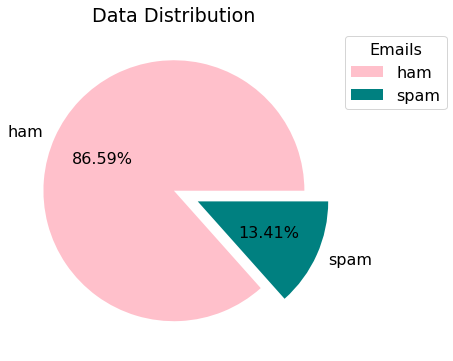

In [6]:
per = round(emails.label.value_counts() / emails.shape[0] * 100, 2)
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 16})
plt.pie(per, labels=['ham', 'spam'], autopct='%.2f%%', colors=['pink','teal'], explode=(0,0.2))
plt.legend(bbox_to_anchor=(1,1), title='Emails')
plt.title('Data Distribution')
plt.show()

### Converting the dataset into textblob and in a list of text

In [7]:
tx_blob = []
text = []

for i in range(len(emails)):
    data = emails['messages'][i]
    tx_blob.append(TextBlob(str(data)))
    text.append(data)

print(tx_blob[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


### Tagging all the words

In [8]:
tag = []
for tx in tx_blob:
    blob = tx.tags
    tag.append(blob)

print(tag[0])

[('Go', 'NNP'), ('until', 'IN'), ('jurong', 'JJ'), ('point', 'NN'), ('crazy..', 'NN'), ('Available', 'JJ'), ('only', 'RB'), ('in', 'IN'), ('bugis', 'NN'), ('n', 'RB'), ('great', 'JJ'), ('world', 'NN'), ('la', 'NN'), ('e', 'FW'), ('buffet', 'NN'), ('Cine', 'NNP'), ('there', 'EX'), ('got', 'VBD'), ('amore', 'RB'), ('wat', 'NN')]


### Forming sentences of emails

In [9]:
sentence = []
for tx in tx_blob:
    blob = tx.sentences
    sentence.append(blob)

print(sentence[0])

[Sentence("Go until jurong point, crazy.."), Sentence("Available only in bugis n great world la e buffet... Cine there got amore wat...")]


### Wordlist of sentence

In [10]:
print(sentence[0][0].words)

['Go', 'until', 'jurong', 'point', 'crazy']


### Correcting the sentence 

In [11]:
print(sentence[0][1].correct())

Available only in boris n great world la e buffets... Line there got more wat...


### Detecting the language of the sentence

In [12]:
print(sentence[0][1].detect_language())

en


### Finding the sentiment of the emails using polarity and subjectivity

In [13]:
polar = []
subj = []

for i in tx_blob:
    polar.append(i.sentiment.polarity)
    subj.append(i.sentiment.subjectivity)

df = pd.DataFrame({'polarity':polar, 'subjectivity':subj})
df.head()

,polarity,subjectivity
0,0.15,0.7625
1,0.50,0.5000
2,0.30,0.5500
3,0.10,0.3000
4,0.00,0.0000


### Ploting a line graph of polarity and subjectivity

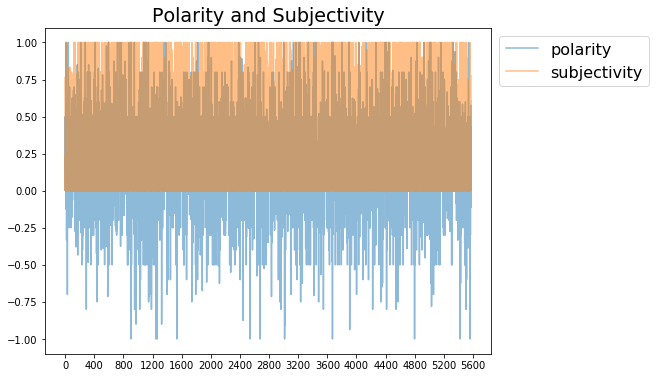

In [14]:
df.plot(title='Polarity and Subjectivity', figsize=(8,6), xticks=np.arange(0,5800,400), alpha=0.5, fontsize=10)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Ploting a density curve of polarity and subjectivity

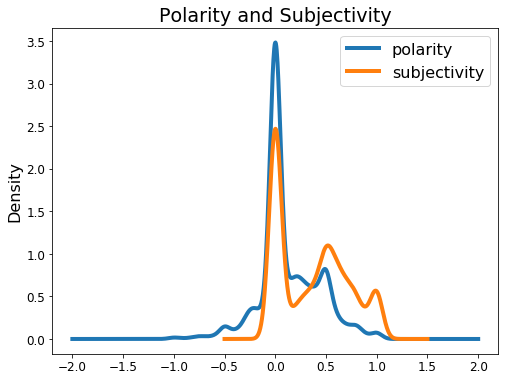

In [15]:
df.plot.density(title='Polarity and Subjectivity', figsize=(8,6), linewidth=4, fontsize=12)
plt.show()

### Ploting a histogram of polarity and subjectivity

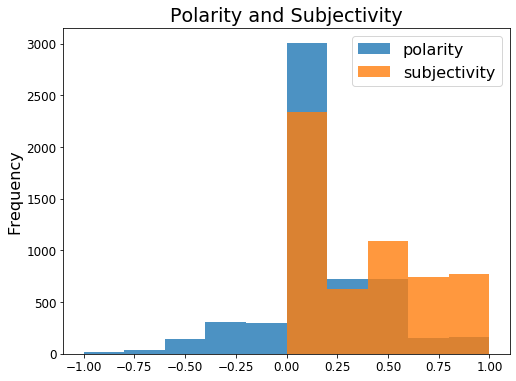

In [16]:
df.plot.hist(title='Polarity and Subjectivity', alpha = 0.8, figsize=(8,6), fontsize=12)
plt.show()

### Ploting a box plot of polarity

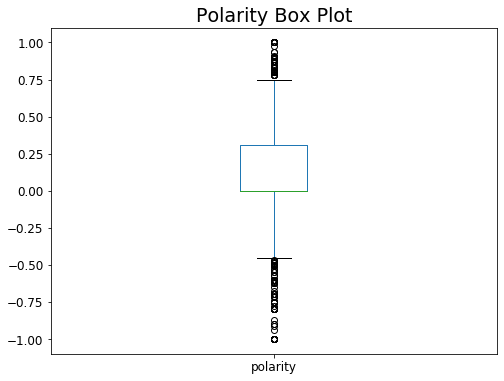

In [17]:
df['polarity'].plot.box(title='Polarity Box Plot', figsize=(8,6), fontsize=12)
plt.show()

### Ploting a box plot of subjectivity

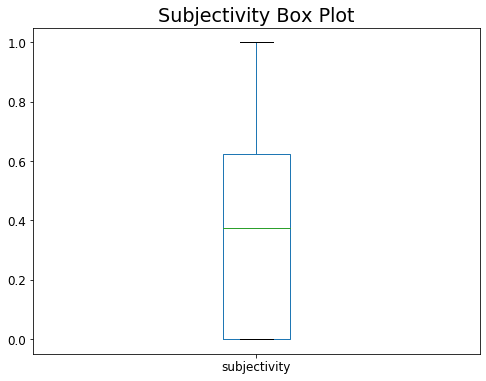

In [18]:
df['subjectivity'].plot.box(title='Subjectivity Box Plot', figsize=(8,6), fontsize=12)
plt.show()

### Using stop words from nltk corpus

In [19]:
stop = stopwords.words('english')
stop.append("I'm")
stop.append("gt")
stop.append("ur")
stop.append("lt")

### Converting the list to a string and then creating a WordCloud

In [20]:
listToStr = ' '.join([str(elem) for elem in text]) 

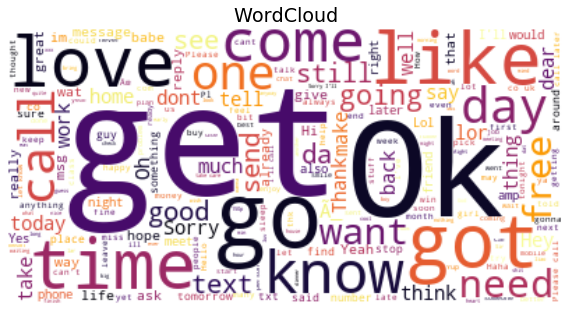

In [21]:
wordcloud = WordCloud(stopwords=stop, max_words=500, colormap='inferno',random_state=7, background_color='white').generate(listToStr)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud')
plt.show()

### Creating a dataframe for spam emails

In [22]:
spam_data = pd.DataFrame(list(emails.groupby(['label']))[1][1])
spam_data.reset_index(inplace=True, drop=True)
spam_data.head()

,label,messages
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,spam,WINNER!! As a valued network customer you have...
3,spam,Had your mobile 11 months or more? U R entitle...
4,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


### Creating a list of all the emails categorized as spam emails 

In [23]:
spam_text = []
for i in range(len(spam_data)):
    data = spam_data['messages'][i]
    spam_text.append(data)
print(spam_text[0])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


### Converting the list to a string and then creating a WordCloud for spam emails

In [24]:
spamToStr = ' '.join([str(elem) for elem in spam_text]) 

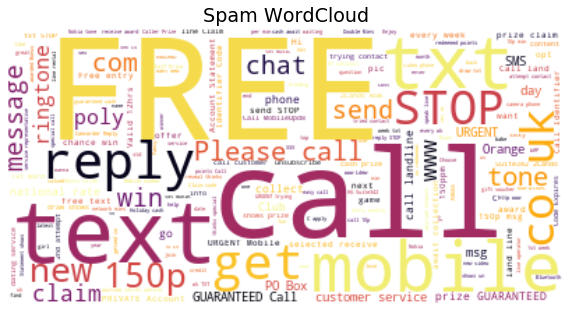

In [25]:
wordcloud = WordCloud(stopwords=stop, max_words=500, colormap='inferno',random_state=7, background_color='white').generate(spamToStr)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam WordCloud')
plt.show()

### Creating a dataframe for ham emails

In [26]:
ham_data = pd.DataFrame(list(emails.groupby(['label']))[0][1])
ham_data.reset_index(inplace=True, drop=True)
ham_data.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...


### Creating a list of all the emails categorized as ham emails 

In [27]:
ham_text = []
for i in range(len(ham_data)):
    data = ham_data['messages'][i]
    ham_text.append(data)
print(ham_text[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


### Converting the list to a string and then creating a WordCloud for ham emails

In [28]:
hamToStr = ' '.join([str(elem) for elem in ham_text]) 

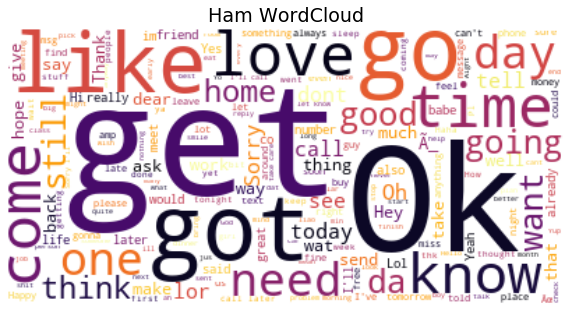

In [29]:
wordcloud = WordCloud(stopwords=stop, max_words=500, colormap='inferno',random_state=7, background_color='white').generate(hamToStr)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ham WordCloud')
plt.show()

### Converting the target data set to binary dataset 

In [30]:
emails['numeric_label'] = emails.label.map({'ham':0,'spam':1})
emails.head()

,label,messages,numeric_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Filtering the data set using regex and nltk corpus

In [31]:
word_list = []
lemmatizer = WordNetLemmatizer()

for i in range(len(emails)):
    text = re.sub('[^a-zA-Z]', ' ', str(emails['messages'][i]))
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    word_list.append(text)

word_list[0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

### Adding a new column of filtered set of words in the data

In [32]:
emails['new_messages'] = word_list
emails.head()

,label,messages,numeric_label,new_messages
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though


###  Assigning values to X and y variable

In [33]:
X = emails['new_messages']
y = emails['numeric_label']
print(X.shape)
print(y.shape)

(5572,)
(5572,)


### Splitting data into train and test set

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


### Making instance of TF-IDF vectorizer

In [35]:
vectorizer = TfidfVectorizer()

### Fitting and transforming the train set using TfidfVectorizer instance

In [36]:
X_train_vect = vectorizer.fit_transform(X_train)
X_train_vect

<4179x6044 sparse matrix of type '<class 'numpy.float64'>'
	with 33736 stored elements in Compressed Sparse Row format>

### Transforming the test set using TfidfVectorizer instance on train set vector

In [37]:
X_test_vect = vectorizer.transform(X_test)
X_test_vect

<1393x6044 sparse matrix of type '<class 'numpy.float64'>'
	with 10021 stored elements in Compressed Sparse Row format>

### Creating a function to calculate the accuracy, precision, recall, f1 score and cohen's kappa score of the algorithms and save them in pandas dataframe

In [38]:
def dataFrame(name, y_true, y_pred):
    df = pd.DataFrame({'Algorithm':[name],
                       'Accuracy':[round(accuracy_score(y_true, y_pred),2)],
                       'Precision':[round(precision_score(y_true, y_pred),2)],
                       'Recall':[round(recall_score(y_true, y_pred),2)],
                       'F1 Score':[round(f1_score(y_true, y_pred),2)],
                       "Cohen's Kappa":[round(cohen_kappa_score(y_true, y_pred),2)]})
    return df

## Machine Learning Algorithms

### 1. Naive Bayes using GridSearchCV to tune hyperparameters

In [39]:
from sklearn.naive_bayes import MultinomialNB

tuned_parameters = [{'alpha':(0.001, 0.01, 0.1, 1)}]
    
naive_bayes = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=tuned_parameters,
                           cv=10)
    
naive_bayes.fit(X_train_vect, y_train)

    
means = naive_bayes.cv_results_['mean_test_score']
stds = naive_bayes.cv_results_['std_test_score']
    
print('Grid scores on the set\n')
    
for mean, std, params in zip(means, stds, naive_bayes.cv_results_['params']):
    print("%0.3f +/- (%0.03f) for %r" %(mean, std * 1.96, params))
        
print('\n\033[1m' + 'Best Parameters: \033[0m \n\n',naive_bayes.best_params_)
print('\033[1m' + '\nBest Score: %0.3f \033[0m' %(naive_bayes.best_score_))
print('\nBest Index:',naive_bayes.best_index_,'\n')
    
y_true, y_pred = y_test, naive_bayes.predict(X_test_vect)
    
print('\033[1m' + 'Confusion matrix\n\n' + '\033[0m',confusion_matrix(y_true,y_pred),'\n')
print('\033[1m' + '\t\t ** Detailed classification report ** '+'\033[0m\n\n',classification_report(y_true, y_pred))

Grid scores on the set

0.974 +/- (0.020) for {'alpha': 0.001}
0.975 +/- (0.020) for {'alpha': 0.01}
0.978 +/- (0.016) for {'alpha': 0.1}
0.969 +/- (0.017) for {'alpha': 1}

Best Parameters:  

 {'alpha': 0.1}

Best Score: 0.978 

Best Index: 2 

Confusion matrix

 [[1195    1]
 [  25  172]] 

		 ** Detailed classification report ** 

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1196
           1       0.99      0.87      0.93       197

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [40]:
df = dataFrame('naive bayes', y_true, y_pred)
df

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
0,naive bayes,0.98,0.99,0.87,0.93,0.92


### 2. Logistic Regression using GridSearchCV to tune hyperparameters

In [41]:
from sklearn.linear_model import LogisticRegression

tuned_parameters = {'tol':[0.0001, 0.001, 0.01],
                    'C':[2,3,4],
                    'max_iter':[5,10,15]}

linear_model = GridSearchCV(estimator=LogisticRegression(random_state=4, n_jobs=-1), param_grid=tuned_parameters,cv=5)

linear_model.fit(X_train_vect, y_train)
    

    
means = linear_model.cv_results_['mean_test_score']
stds = linear_model.cv_results_['std_test_score']
    
print('Grid scores on the set\n')
    
for mean, std, params in zip(means, stds, linear_model.cv_results_['params']):
    print("%0.3f +/- (%0.03f) for %r" %(mean, std * 1.96, params))
        
print('\n\033[1m' + 'Best Parameters: \033[0m \n\n',linear_model.best_params_)        
print('\033[1m' + '\nBest Score: %0.3f \033[0m' %(linear_model.best_score_))
print('\nBest Index:',linear_model.best_index_,'\n')
    
y_true, y_pred = y_test, linear_model.predict(X_test_vect)
    
print('\033[1m' + 'Confusion matrix\n\n' + '\033[0m',confusion_matrix(y_true,y_pred),'\n')
print('\033[1m' + '\t\t ** Detailed classification report ** '+'\033[0m\n\n',classification_report(y_true, y_pred))

Grid scores on the set

0.868 +/- (0.000) for {'C': 2, 'max_iter': 5, 'tol': 0.0001}
0.868 +/- (0.000) for {'C': 2, 'max_iter': 5, 'tol': 0.001}
0.868 +/- (0.000) for {'C': 2, 'max_iter': 5, 'tol': 0.01}
0.954 +/- (0.013) for {'C': 2, 'max_iter': 10, 'tol': 0.0001}
0.954 +/- (0.013) for {'C': 2, 'max_iter': 10, 'tol': 0.001}
0.954 +/- (0.013) for {'C': 2, 'max_iter': 10, 'tol': 0.01}
0.962 +/- (0.016) for {'C': 2, 'max_iter': 15, 'tol': 0.0001}
0.962 +/- (0.016) for {'C': 2, 'max_iter': 15, 'tol': 0.001}
0.962 +/- (0.016) for {'C': 2, 'max_iter': 15, 'tol': 0.01}
0.868 +/- (0.000) for {'C': 3, 'max_iter': 5, 'tol': 0.0001}
0.868 +/- (0.000) for {'C': 3, 'max_iter': 5, 'tol': 0.001}
0.868 +/- (0.000) for {'C': 3, 'max_iter': 5, 'tol': 0.01}
0.954 +/- (0.012) for {'C': 3, 'max_iter': 10, 'tol': 0.0001}
0.954 +/- (0.012) for {'C': 3, 'max_iter': 10, 'tol': 0.001}
0.954 +/- (0.012) for {'C': 3, 'max_iter': 10, 'tol': 0.01}
0.972 +/- (0.018) for {'C': 3, 'max_iter': 15, 'tol': 0.0001}
0.972

In [42]:
df = df.append(dataFrame('logistic regression', y_true, y_pred), ignore_index=True)
df

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
0,naive bayes,0.98,0.99,0.87,0.93,0.92
1,logistic regression,0.97,0.98,0.82,0.89,0.87


### 3. Support Vector Machines using GridSearchCV to tune hyperparameters

In [43]:
from sklearn.svm import SVC

tuned_parameters = {'C':[2,3,4],
                    'degree':[1,2],
                    'kernel':['rbf','sigmoid','poly']}

svm = GridSearchCV(estimator=SVC(random_state=4), 
                   param_grid=tuned_parameters,
                   cv=5)

svm.fit(X_train_vect, y_train)
    
means = svm.cv_results_['mean_test_score']
stds = svm.cv_results_['std_test_score']
    
print('Grid scores on the set\n')
    
for mean, std, params in zip(means, stds, svm.cv_results_['params']):
    print("%0.3f +/- (%0.03f) for %r" %(mean, std * 1.96, params))
        
print('\n\033[1m' + 'Best Parameters: \033[0m \n\n',svm.best_params_)        
print('\033[1m' + '\nBest Score: %0.3f \033[0m' %(svm.best_score_))
print('\nBest Index:',svm.best_index_,'\n')
    
y_true, y_pred = y_test, svm.predict(X_test_vect)
    
print('\033[1m' + 'Confusion matrix\n\n' + '\033[0m',confusion_matrix(y_true,y_pred),'\n')
print('\033[1m' + '\t\t ** Detailed classification report ** '+'\033[0m\n\n',classification_report(y_true, y_pred))

Grid scores on the set

0.975 +/- (0.009) for {'C': 2, 'degree': 1, 'kernel': 'rbf'}
0.980 +/- (0.011) for {'C': 2, 'degree': 1, 'kernel': 'sigmoid'}
0.983 +/- (0.010) for {'C': 2, 'degree': 1, 'kernel': 'poly'}
0.975 +/- (0.009) for {'C': 2, 'degree': 2, 'kernel': 'rbf'}
0.980 +/- (0.011) for {'C': 2, 'degree': 2, 'kernel': 'sigmoid'}
0.955 +/- (0.010) for {'C': 2, 'degree': 2, 'kernel': 'poly'}
0.976 +/- (0.009) for {'C': 3, 'degree': 1, 'kernel': 'rbf'}
0.980 +/- (0.012) for {'C': 3, 'degree': 1, 'kernel': 'sigmoid'}
0.983 +/- (0.008) for {'C': 3, 'degree': 1, 'kernel': 'poly'}
0.976 +/- (0.009) for {'C': 3, 'degree': 2, 'kernel': 'rbf'}
0.980 +/- (0.012) for {'C': 3, 'degree': 2, 'kernel': 'sigmoid'}
0.955 +/- (0.011) for {'C': 3, 'degree': 2, 'kernel': 'poly'}
0.976 +/- (0.009) for {'C': 4, 'degree': 1, 'kernel': 'rbf'}
0.978 +/- (0.011) for {'C': 4, 'degree': 1, 'kernel': 'sigmoid'}
0.983 +/- (0.007) for {'C': 4, 'degree': 1, 'kernel': 'poly'}
0.976 +/- (0.009) for {'C': 4, 'degr

In [44]:
df = df.append(dataFrame('support vector machines', y_true, y_pred), ignore_index=True)
df

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
0,naive bayes,0.98,0.99,0.87,0.93,0.92
1,logistic regression,0.97,0.98,0.82,0.89,0.87
2,support vector machines,0.98,0.99,0.88,0.94,0.93


### 4. Neural Networks using GridSearchCV to tune hyperparameters

In [45]:
from sklearn.neural_network import MLPClassifier

tuned_parameters = {'activation':['relu','logistic','tanh']}

neural_networks = GridSearchCV(estimator=MLPClassifier(random_state=4), param_grid=tuned_parameters, cv=5)

neural_networks.fit(X_train_vect, y_train)
    

    
means = neural_networks.cv_results_['mean_test_score']
stds = neural_networks.cv_results_['std_test_score']
    
print('Grid scores on the set\n')
    
for mean, std, params in zip(means, stds, neural_networks.cv_results_['params']):
    print("%0.3f +/- (%0.03f) for %r" %(mean, std * 1.96, params))
        
print('\n\033[1m' + 'Best Parameters: \033[0m \n\n',neural_networks.best_params_)
print('\033[1m' + '\nBest Score: %0.3f \033[0m' %(neural_networks.best_score_))
print('\nBest Index:',neural_networks.best_index_,'\n')
    
y_true, y_pred = y_test, neural_networks.predict(X_test_vect)
    
print('\033[1m' + 'Confusion matrix\n\n' + '\033[0m',confusion_matrix(y_true,y_pred),'\n')
print('\033[1m' + '\t\t ** Detailed classification report ** '+'\033[0m\n\n',classification_report(y_true, y_pred))

Grid scores on the set

0.983 +/- (0.010) for {'activation': 'relu'}
0.982 +/- (0.005) for {'activation': 'logistic'}
0.982 +/- (0.008) for {'activation': 'tanh'}

Best Parameters:  

 {'activation': 'relu'}

Best Score: 0.983 

Best Index: 0 

Confusion matrix

 [[1195    1]
 [  25  172]] 

		 ** Detailed classification report ** 

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1196
           1       0.99      0.87      0.93       197

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [46]:
df = df.append(dataFrame('neural networks', y_true, y_pred), ignore_index=True)
df

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
0,naive bayes,0.98,0.99,0.87,0.93,0.92
1,logistic regression,0.97,0.98,0.82,0.89,0.87
2,support vector machines,0.98,0.99,0.88,0.94,0.93
3,neural networks,0.98,0.99,0.87,0.93,0.92


### 5. Random Forest using GridSearchCV to tune hyperparameters

In [47]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {'criterion':['gini','entropy'],
                    'n_estimators':[20,50,80,100]}

random_forest = GridSearchCV(estimator=RandomForestClassifier(random_state=6), param_grid=tuned_parameters, cv=5)

random_forest.fit(X_train_vect, y_train)
    
means = random_forest.cv_results_['mean_test_score']
stds = random_forest.cv_results_['std_test_score']
    
print('Grid scores on the set\n')
    
for mean, std, params in zip(means, stds, random_forest.cv_results_['params']):
    print("%0.3f +/- (%0.03f) for %r" %(mean, std * 1.96, params))
        
print('\n\033[1m' + 'Best Parameters: \033[0m \n\n',random_forest.best_params_)
print('\033[1m' + '\nBest Score: %0.3f \033[0m' %(random_forest.best_score_))
print('\nBest Index:',random_forest.best_index_,'\n')
    
y_true, y_pred = y_test, random_forest.predict(X_test_vect)
    
print('\033[1m' + 'Confusion matrix\n\n' + '\033[0m',confusion_matrix(y_true,y_pred),'\n')
print('\033[1m' + '\t\t ** Detailed classification report ** '+'\033[0m\n\n',classification_report(y_true, y_pred))

Grid scores on the set

0.973 +/- (0.004) for {'criterion': 'gini', 'n_estimators': 20}
0.976 +/- (0.005) for {'criterion': 'gini', 'n_estimators': 50}
0.977 +/- (0.007) for {'criterion': 'gini', 'n_estimators': 80}
0.977 +/- (0.007) for {'criterion': 'gini', 'n_estimators': 100}
0.976 +/- (0.010) for {'criterion': 'entropy', 'n_estimators': 20}
0.978 +/- (0.010) for {'criterion': 'entropy', 'n_estimators': 50}
0.978 +/- (0.007) for {'criterion': 'entropy', 'n_estimators': 80}
0.978 +/- (0.006) for {'criterion': 'entropy', 'n_estimators': 100}

Best Parameters:  

 {'criterion': 'entropy', 'n_estimators': 80}

Best Score: 0.978 

Best Index: 6 

Confusion matrix

 [[1196    0]
 [  46  151]] 

		 ** Detailed classification report ** 

               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1196
           1       1.00      0.77      0.87       197

    accuracy                           0.97      1393
   macro avg       0.98      0.88    

In [48]:
df = df.append(dataFrame('random forest', y_true, y_pred), ignore_index=True)
df

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
0,naive bayes,0.98,0.99,0.87,0.93,0.92
1,logistic regression,0.97,0.98,0.82,0.89,0.87
2,support vector machines,0.98,0.99,0.88,0.94,0.93
3,neural networks,0.98,0.99,0.87,0.93,0.92
4,random forest,0.97,1.00,0.77,0.87,0.85


### 6. K Nearest Neighbor using GridSearchCV to tune hyperparameters

In [49]:
from sklearn.neighbors import KNeighborsClassifier

tuned_parameters = {'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'n_neighbors':[1,2],
                    'weights':['uniform','distance']}

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=tuned_parameters, cv=5)

knn.fit(X_train_vect, y_train)
    
means = knn.cv_results_['mean_test_score']
stds = knn.cv_results_['std_test_score']
    
print('Grid scores on the set\n')
    
for mean, std, params in zip(means, stds, knn.cv_results_['params']):
    print("%0.3f +/- (%0.03f) for %r" %(mean, std * 1.96, params))
        
print('\n\033[1m' + 'Best Parameters: \033[0m \n\n',knn.best_params_)
print('\033[1m' + '\nBest Score: %0.3f \033[0m' %(knn.best_score_))
print('\nBest Index:',knn.best_index_,'\n')
    
y_true, y_pred = y_test, knn.predict(X_test_vect)
    
print('\033[1m' + 'Confusion matrix\n\n' + '\033[0m',confusion_matrix(y_true,y_pred),'\n')
print('\033[1m' + '\t\t ** Detailed classification report ** '+'\033[0m\n\n',classification_report(y_true, y_pred))

Grid scores on the set

0.943 +/- (0.003) for {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
0.943 +/- (0.003) for {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'distance'}
0.922 +/- (0.003) for {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
0.943 +/- (0.003) for {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}
0.943 +/- (0.003) for {'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}
0.943 +/- (0.003) for {'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'distance'}
0.922 +/- (0.003) for {'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'uniform'}
0.943 +/- (0.003) for {'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'distance'}
0.943 +/- (0.003) for {'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'uniform'}
0.943 +/- (0.003) for {'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'distance'}
0.922 +/- (0.003) for {'algorithm': 'kd_tree', 'n_neighbors': 2, 'weights': 'uniform'}
0.943 +/- (0.003) 

In [50]:
df = df.append(dataFrame('k nearest neighbor', y_true, y_pred), ignore_index=True)
df

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
0,naive bayes,0.98,0.99,0.87,0.93,0.92
1,logistic regression,0.97,0.98,0.82,0.89,0.87
2,support vector machines,0.98,0.99,0.88,0.94,0.93
3,neural networks,0.98,0.99,0.87,0.93,0.92
4,random forest,0.97,1.00,0.77,0.87,0.85
5,k nearest neighbor,0.95,0.98,0.65,0.78,0.76


## Model comparision based on accuracy, precision, recall, f1-score and cohen's kappa score

In [51]:
df.sort_values(by="Cohen's Kappa", ascending=False)

,Algorithm,Accuracy,Precision,Recall,f1 Score,Cohen's Kappa
2,support vector machines,0.98,0.99,0.88,0.94,0.93
0,naive bayes,0.98,0.99,0.87,0.93,0.92
3,neural networks,0.98,0.99,0.87,0.93,0.92
1,logistic regression,0.97,0.98,0.82,0.89,0.87
4,random forest,0.97,1.00,0.77,0.87,0.85
5,k nearest neighbor,0.95,0.98,0.65,0.78,0.76


# Conclusion

## ***1. Based on F1 score and cohen's kappa score, we can see that Support Vector Machine (SVM) is the best algorithm for our dataset.***

## ***2. The best hyper tuning parameters used in SVM are:***
## ***{'C': 3, 'degree': 1, 'kernel': 'poly’}***

# References
- Kaggle
- Wikipedia
- towardsdatascience.com
- scikit-learn.org
- GitHub